In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import mobilenet_v2
from sklearn.model_selection import train_test_split

In [2]:
dataset_dir = 'dataset'
images_dir = os.path.join(dataset_dir, 'images')
labels_csv = os.path.join(dataset_dir, 'labels.csv')

In [3]:
# Load the model if exists
model = None
if os.path.exists('siamese_model.keras'):
    model = tf.keras.models.load_model('siamese_model.keras')
    print("Model loaded successfully")

In [61]:
from sklearn.preprocessing import MultiLabelBinarizer
from scipy.spatial import distance

def siamese_model(input_shape):
    base_model = mobilenet_v2.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.trainable = False

    input1 = keras.Input(shape=input_shape)
    input2 = keras.Input(shape=input_shape)

    x1 = base_model(input1)
    x2 = base_model(input2)
    
    pooled_1 = layers.GlobalAveragePooling2D()(x1)
    pooled_2 = layers.GlobalAveragePooling2D()(x2)

    x = layers.Concatenate()([pooled_1, pooled_2])
    # x = layers.Flatten()(x)
    x = layers.Dense(1024, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=[input1, input2], outputs=output)
    return model

def retrain_model(model, input_shape, classes):
    if model is None:
        model = siamese_model(input_shape)

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, train_data, train_labels, epochs):
    model.fit(train_data, train_labels, epochs=epochs)
    return model

def load_dataset(images_dir, labels_csv, input_shape, batch_size=32):
    labels_df = pd.read_csv(labels_csv, sep=',')
    labels_list = labels_df.iloc[:, 1:].values
    images = []

    for img_name in labels_df.iloc[:, 0]:
        img_path = os.path.join(images_dir, img_name)
        img = keras.preprocessing.image.load_img(img_path, target_size=input_shape)
        img_array = keras.preprocessing.image.img_to_array(img)
        images.append(img_array)

    images = np.array(images)
    
    labels = [label.split(';') for label in labels_df.iloc[:, 1]]
    classes = sorted(set([item for sublist in labels for item in sublist]))
    mlb = MultiLabelBinarizer(classes=classes)
    labels = mlb.fit_transform(labels)
    
    def pair_generator(images, labels, batch_size):
        num_samples = len(images)
        while True:
            image_pairs_1 = []
            image_pairs_2 = []
            pair_labels = []
            for _ in range(batch_size):
                idx1 = np.random.randint(0, num_samples)
                idx2 = np.random.randint(0, num_samples)
                image_pairs_1.append(images[idx1])
                image_pairs_2.append(images[idx2])
                
                hamming_diff = distance.hamming(labels[idx1], labels[idx2])
                euclidean_diff = distance.euclidean(labels[idx1], labels[idx2])
                diff = (hamming_diff + euclidean_diff) / 2
                similarity_threshold = 0.4

                pair_labels.append([1 if diff <= similarity_threshold else 0])
            yield [np.array(image_pairs_1), np.array(image_pairs_2)], np.array(pair_labels).reshape(-1, 1)

    input_shape = images[0].shape
    return pair_generator(images, labels, batch_size), classes, input_shape

In [55]:
# Load dataset (siamese version)
generator, classes, input_shape = load_dataset(images_dir, labels_csv, (224,224))

In [62]:
# Retrain model or make a new one if missing
# model = None
model = retrain_model(model, input_shape, classes)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)           2257984   ['input_8[0][0]',             
 tional)                                                             'input_9[0][0]']             
                                                                                                  
 global_average_pooling2d (  (None, 1280)                 0         ['mobilenetv2_1.00_224[0

(32, 224, 224, 3) (32, 224, 224, 3) (32, 1)
[[0]
 [0]
 [0]
 [0]
 [0]]


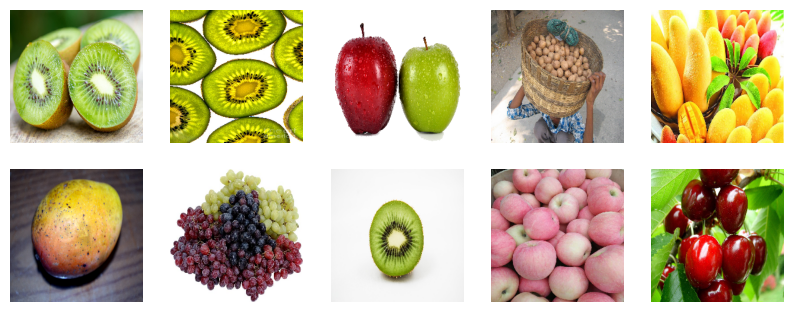

(32, 224, 224, 3) (32, 224, 224, 3) (32, 1)
[[0]
 [0]
 [0]
 [0]
 [0]]


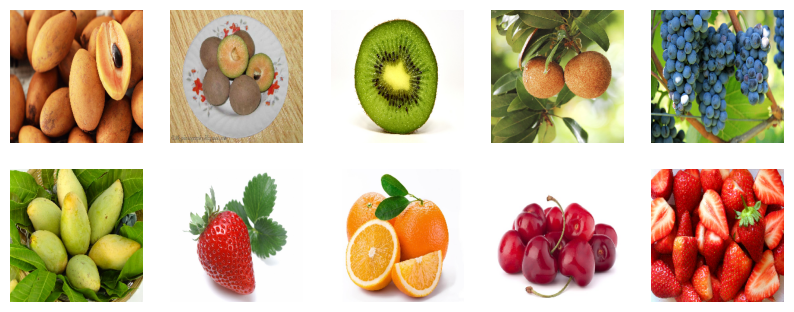

(32, 224, 224, 3) (32, 224, 224, 3) (32, 1)
[[0]
 [0]
 [0]
 [0]
 [0]]


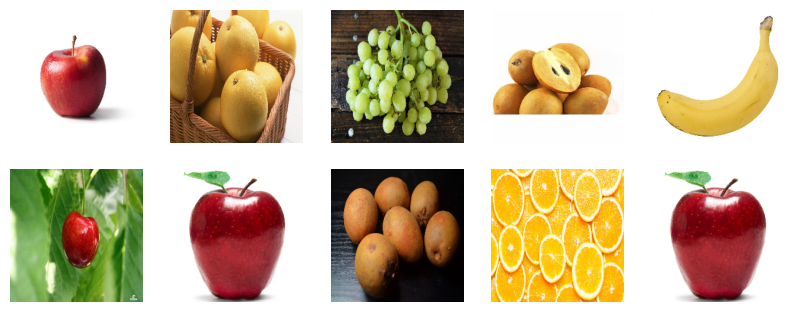

(32, 224, 224, 3) (32, 224, 224, 3) (32, 1)
[[0]
 [1]
 [0]
 [0]
 [0]]


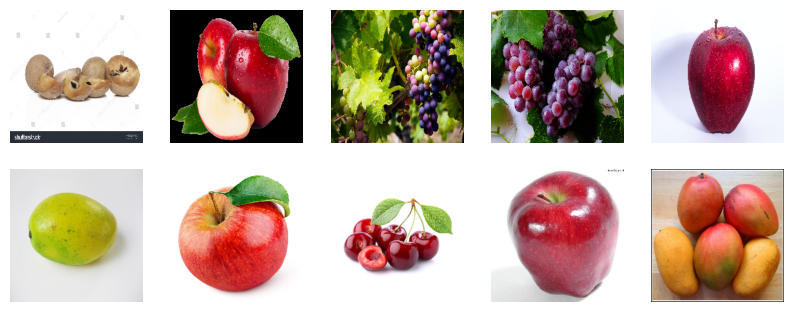

(32, 224, 224, 3) (32, 224, 224, 3) (32, 1)
[[1]
 [0]
 [0]
 [0]
 [0]]


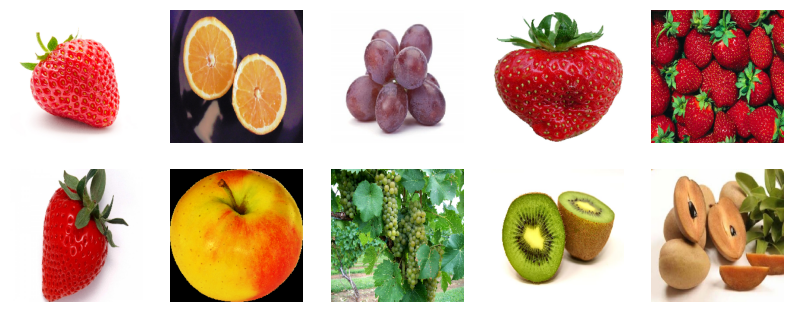

In [56]:
# Test generator
for i in range(5):
    (image_pairs, labels) = next(generator)
    print(image_pairs[0].shape, image_pairs[1].shape, labels.shape)
    print(labels[:5])
    
    plt.figure(figsize=(10, 10))
    for i in range(5):
        plt.subplot(5, 5, i + 1)
        plt.imshow(image_pairs[0][i] / 255)
        plt.axis('off')
        
        plt.subplot(5, 5, i + 6)
        plt.imshow(image_pairs[1][i] / 255)
        plt.axis('off')
    plt.show()

In [67]:
from tensorflow.keras.callbacks import EarlyStopping

# Define training settings
train_settings = {
    'epochs': 30,
    'callbacks': [
        EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
    ],
    'validation_steps': 10,
    'steps_per_epoch': 10,
    'batch_size': 32,
}

# Train the model with the settings
history = model.fit(generator, epochs=train_settings['epochs'], callbacks=train_settings['callbacks'], steps_per_epoch=train_settings['steps_per_epoch'], validation_steps=train_settings['validation_steps'], batch_size=train_settings['batch_size'])

Epoch 1/30
10/10 [==============================] - 19s 2s/step - loss: 0.2991 - accuracy: 0.9125
Epoch 2/30
10/10 [==============================] - 25s 3s/step - loss: 0.2779 - accuracy: 0.9281
Epoch 3/30
10/10 [==============================] - 22s 2s/step - loss: 0.3000 - accuracy: 0.9219
Epoch 4/30
10/10 [==============================] - 19s 2s/step - loss: 0.2770 - accuracy: 0.9250
Epoch 5/30
10/10 [==============================] - 22s 2s/step - loss: 0.2963 - accuracy: 0.9187
Epoch 6/30
10/10 [==============================] - 25s 3s/step - loss: 0.2750 - accuracy: 0.9219
Epoch 7/30
10/10 [==============================] - 22s 2s/step - loss: 0.2929 - accuracy: 0.9156
Epoch 8/30
10/10 [==============================] - 24s 2s/step - loss: 0.2728 - accuracy: 0.9281
Epoch 9/30
10/10 [==============================] - 24s 2s/step - loss: 0.3070 - accuracy: 0.9125
Epoch 10/30
10/10 [==============================] - 17s 2s/step - loss: 0.2948 - accuracy: 0.9156
Epoch 11/30
10/10 [

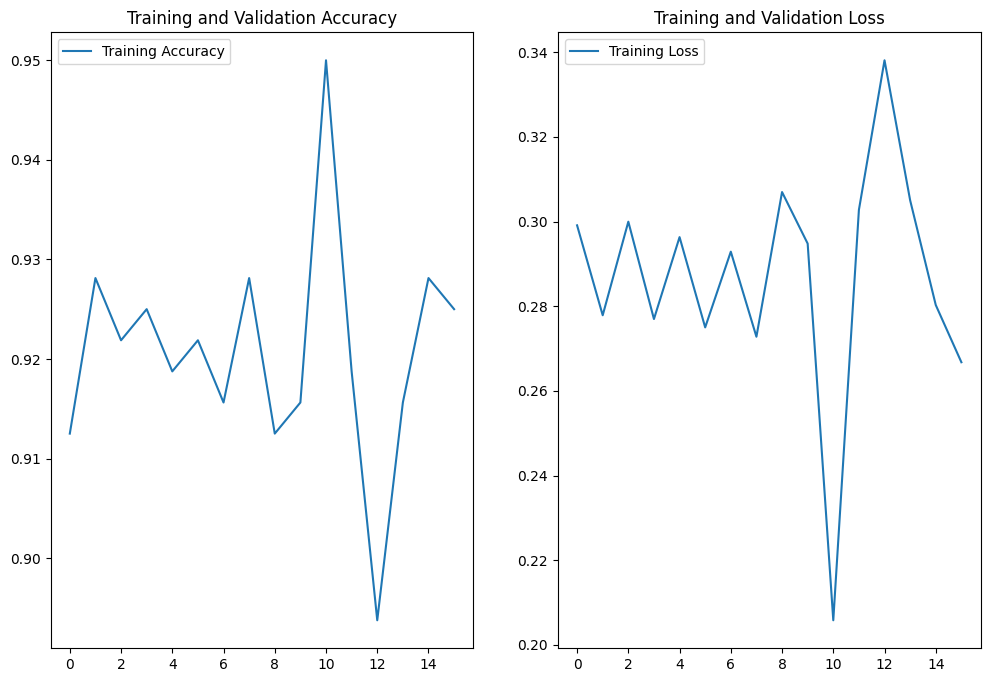

In [69]:
def plot_history(history):
    acc = history.history['accuracy']
    # val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    # val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    # plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    # plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Plot the training history
plot_history(history)

1/1 [==============================] - 6s 6s/step


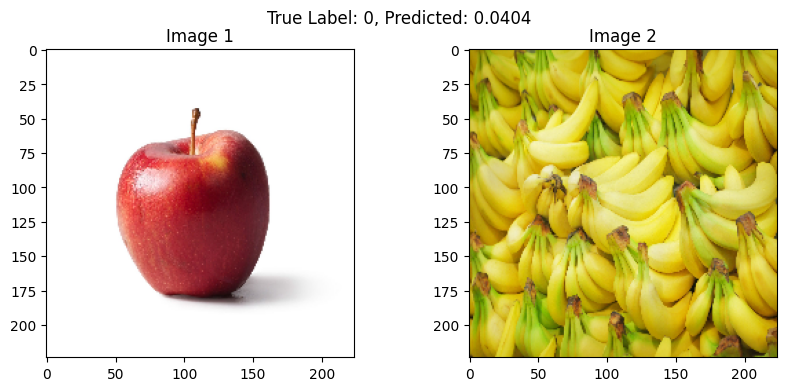

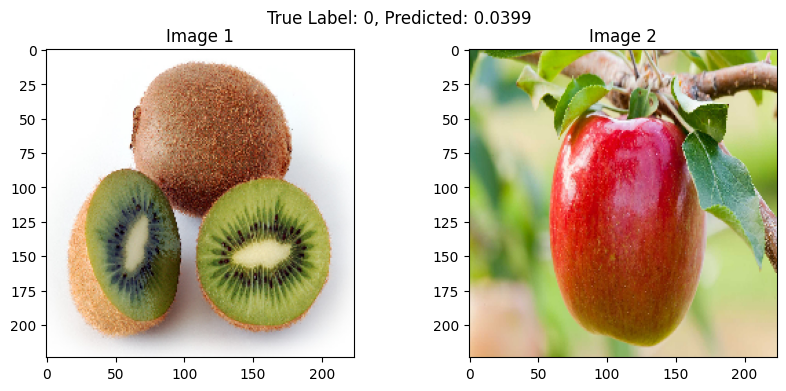

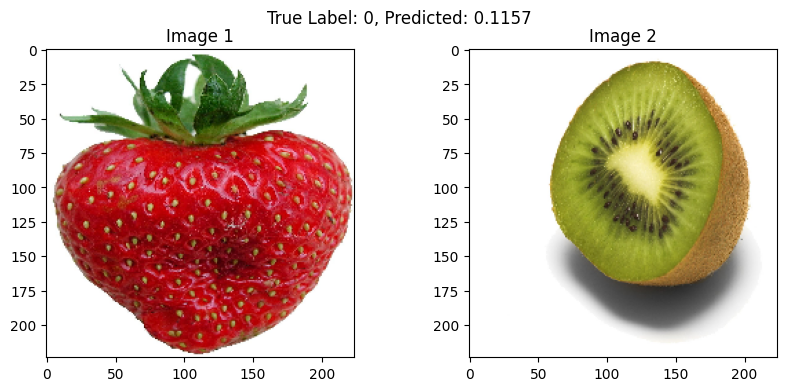

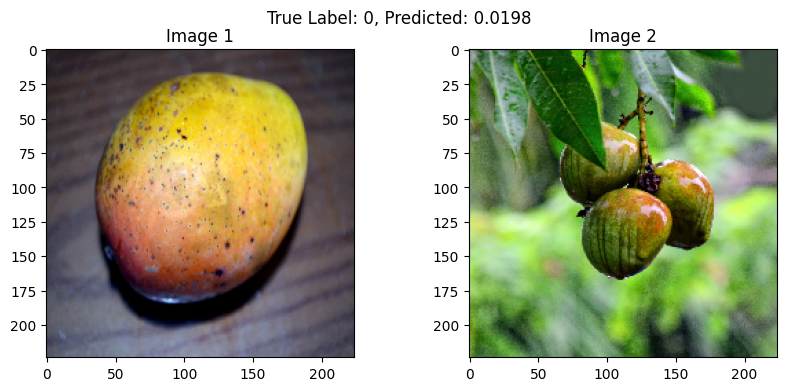

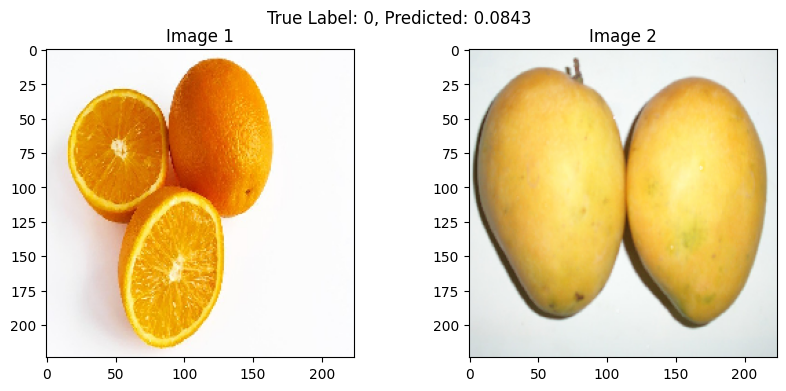

In [70]:
def visualize_predictions(model, test_pairs, test_labels, num_samples=5):
    predictions = model.predict(test_pairs)
    
    for i in range(num_samples):
        plt.figure(figsize=(10, 4))
        
        plt.subplot(1, 2, 1)
        plt.imshow(test_pairs[0][i].astype('uint8'))
        plt.title('Image 1')
        
        plt.subplot(1, 2, 2)
        plt.imshow(test_pairs[1][i].astype('uint8'))
        plt.title('Image 2')
        
        plt.suptitle(f"True Label: {test_labels[i][0]}, Predicted: {predictions[i][0]:.4f}")
        plt.show()

# Visualize some predictions
(test_pairs, test_labels) = next(generator)
visualize_predictions(model, test_pairs, test_labels)

In [71]:
# Save model
model.save('siamese_model.keras')
print("Model saved successfully")

Model saved successfully
